<a href="https://colab.research.google.com/github/xquynhtrinh/STA_141C_Final_Project/blob/main/EDA_Online_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA Goals

1. Clean data (missing IDs, cancellations, bad prices/qtys)
2. Understand distributions -> justify log-transform before K-Means
3. Build RFM table
4. Compute correlation matrix -> decide if PCA is warranted
5. Check class imbalance -> plan for predictive modeling

In [69]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", palette="muted")

## Load Data

Merge two sheets: 2009-2010 and 2010-2011

In [27]:
# has 2 sheets: 2009-2010 and 2010-2011
df_1 = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/STA 141C/online_retail_II.xlsx", sheet_name="Year 2009-2010")
df_2 = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/STA 141C/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = pd.concat([df_1, df_2], ignore_index=True)


In [19]:
df.shape

(1067371, 8)

## Clean Data

In [29]:
# Remove rows with missing Customer ID
df = df.dropna(subset=["Customer ID"])

# Remove cancelled invoices (starts w/ C)
cancelled = df[df["Invoice"].astype(str).str.startswith("C")]
df = df[~df["Invoice"].astype(str).str.startswith("C")]

# Remove non-pos Quantity & Price
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]

# Fix data types
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["Customer ID"] = df["Customer ID"].astype(int).astype(str)

# Remove duplicates
df = df.drop_duplicates()

# Shape after cleaning
df.shape


(779425, 8)

### Data Cleaning Summary

We started with 1067371 rows and ended with 779425 rows and5878 unique customers in the RFM table.

-> ~27% drop is mostly from removing null Customer IDs

## Add Revenue Column

In [53]:
df["Revenue"] = df["Quantity"] * df["Price"]
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0,30.0


## Transaction-level

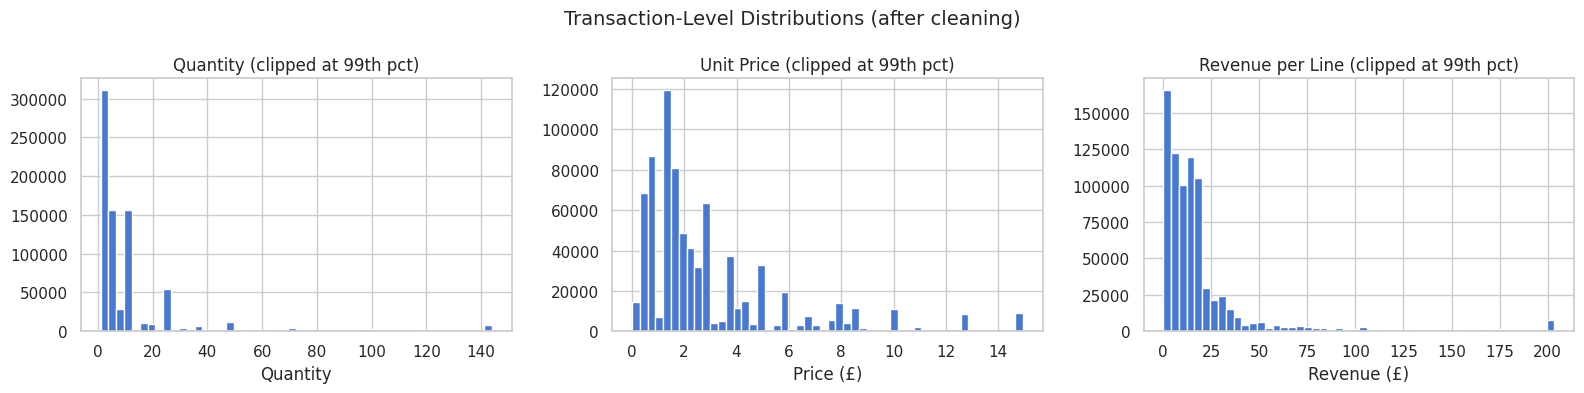

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("Transaction-Level Distributions (after cleaning)", fontsize=14)

# Quantity
axes[0].hist(df["Quantity"].clip(upper=df["Quantity"].quantile(0.99)),
             bins=50, edgecolor="white")
axes[0].set_title("Quantity (clipped at 99th pct)")
axes[0].set_xlabel("Quantity")

# Unit Price
axes[1].hist(df["Price"].clip(upper=df["Price"].quantile(0.99)),
             bins=50, edgecolor="white")
axes[1].set_title("Unit Price (clipped at 99th pct)")
axes[1].set_xlabel("Price (£)")

# Revenue per line
axes[2].hist(df["Revenue"].clip(upper=df["Revenue"].quantile(0.99)),
             bins=50, edgecolor="white")
axes[2].set_title("Revenue per Line (clipped at 99th pct)")
axes[2].set_xlabel("Revenue (£)")

plt.tight_layout()
plt.savefig("eda_transaction_distributions.png", dpi=150)
plt.show()

## Sales Over Time

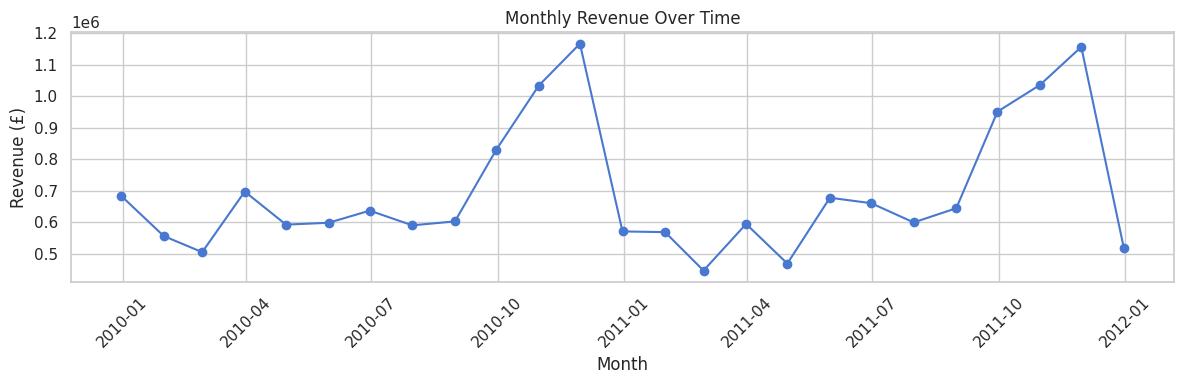

In [55]:
monthly = (df.set_index("InvoiceDate")
             .resample("M")["Revenue"]
             .sum()
             .reset_index())

plt.figure(figsize=(12, 4))
plt.plot(monthly["InvoiceDate"], monthly["Revenue"], marker="o")
plt.title("Monthly Revenue Over Time")
plt.xlabel("Month")
plt.ylabel("Revenue (£)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("eda_monthly_revenue.png", dpi=150)
plt.show()

### Summary Sales

There are spikes around Nov-Dec in both 2010 and 2011.

Since the dataset ends Dec 9, 2011, the "last 90 days" holdout window covers Sep-Dec 2011 -> holiday season.

This means binary target slightly over-represents holiday buyers -> this is a limitation and we might consider whether using a non-seasonal 90-day window.

## Build RFM Table

In [59]:
# Use the day AFTER the last invoice date as the reference "today"
reference_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
print(f"\nReference date for Recency: {reference_date.date()}")

rfm = (df.groupby("Customer ID")
         .agg(
             Recency   = ("InvoiceDate", lambda x: (reference_date - x.max()).days),
             Frequency = ("Invoice",     "nunique"),   # unique invoices, not line items
             Monetary  = ("Revenue",     "sum")
         )
         .reset_index())
rfm[["Recency", "Frequency", "Monetary"]].describe().round(2)


Reference date for Recency: 2011-12-10


,Recency,Frequency,Monetary
count,5878.00,5878.00,5878.00
mean,201.33,6.29,2955.90
std,209.34,13.01,14440.85
min,1.00,1.00,2.95
25%,26.00,1.00,342.28
50%,96.00,3.00,867.74
75%,380.00,7.00,2248.30
max,739.00,398.00,580987.04


## RFM Distribution Plots

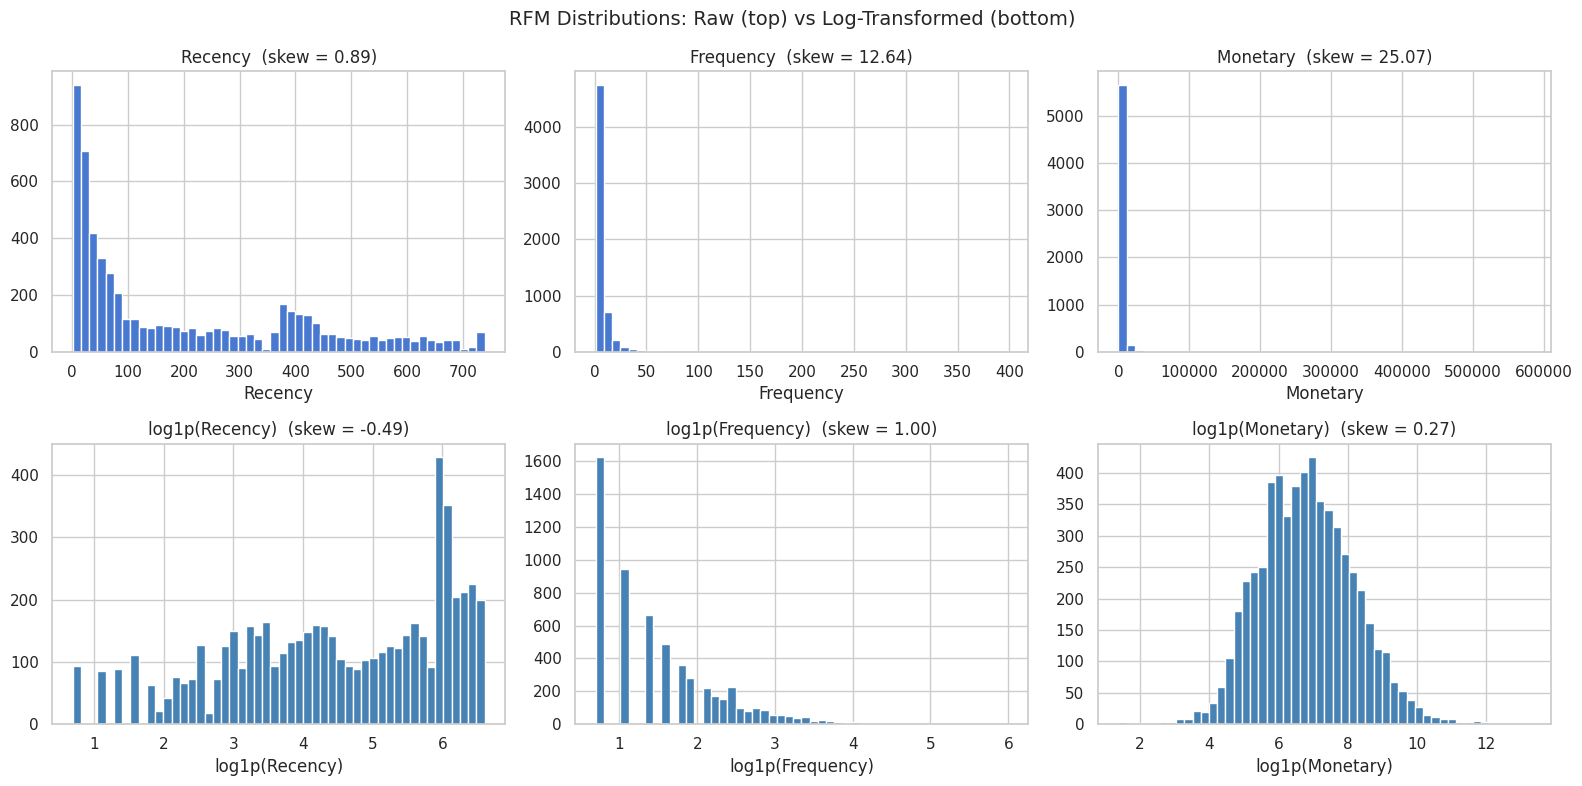

In [74]:
# Visualize raw vs log-transf. to justify log trans before K-means
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle("RFM Distributions: Raw (top) vs Log-Transformed (bottom)", fontsize=14)

cols = ["Recency", "Frequency", "Monetary"]
for i, col in enumerate(cols):
    # Raw
    skew_val = rfm[col].skew()
    axes[0, i].hist(rfm[col], bins=50, edgecolor="white")
    axes[0, i].set_title(f"{col}  (skew = {skew_val:.2f})")
    axes[0, i].set_xlabel(col)

    # Log-transformed (log1p to handle potential zeros)
    log_data = np.log1p(rfm[col])
    log_skew = log_data.skew()
    axes[1, i].hist(log_data, bins=50, edgecolor="white", color="steelblue")
    axes[1, i].set_title(f"log1p({col})  (skew = {log_skew:.2f})")
    axes[1, i].set_xlabel(f"log1p({col})")

plt.tight_layout()
plt.savefig("eda_rfm_distributions.png", dpi=150)
plt.show()



### Summary RFM Distribution

Frequency and Monetary exhibit extreme right skew (12.64 and 25.07 respectively), violating K-Means' implicit assumption that features are roughly symmetric. A log1p transform reduces these to 1.00 and 0.27. All subsequent clustering uses log-transformed, standardized features.

## Correlation matrix

This checks if we need PCA

- If |r| between any pair is large (>.6), PCA helps
- else, PCA hurts interpretability

In [82]:
corr_raw = rfm[cols].corr()
corr_log = pd.DataFrame(
    np.corrcoef([np.log1p(rfm[c]) for c in cols]),
    index=cols, columns=cols
)

print("Correlation Matrix — Raw RFM")
print(corr_raw.round(3))

print("\nCorrelation Matrix - Log-Transformation")
print(corr_log.round(3))

Correlation Matrix — Raw RFM
           Recency  Frequency  Monetary
Recency      1.000     -0.257    -0.125
Frequency   -0.257      1.000     0.628
Monetary    -0.125      0.628     1.000

Correlation Matrix - Log-Transformation
           Recency  Frequency  Monetary
Recency      1.000     -0.562    -0.505
Frequency   -0.562      1.000     0.850
Monetary    -0.505      0.850     1.000


### Summary Correlation Matrix

After log-transf:

- F-M: r = .85 -> very high multicollinearity

- R-F: r = -.56 -> moderate

- R-M: r = -.5 -> moderate

This show F and M share 72% of variance $(r^2 = .86^2 \approx .72)$. Thus, PCA on the log-RFM space is well-motivated

In conclusion, the log-transformed correlation between Frequency and Monetary is 0.85, indicating substantial multicollinearity. PCA is applied to decorrelate features before logistic regression, preventing inflated coefficient variance.

## Pairplot

This checks for linearity assumption & cluster separability

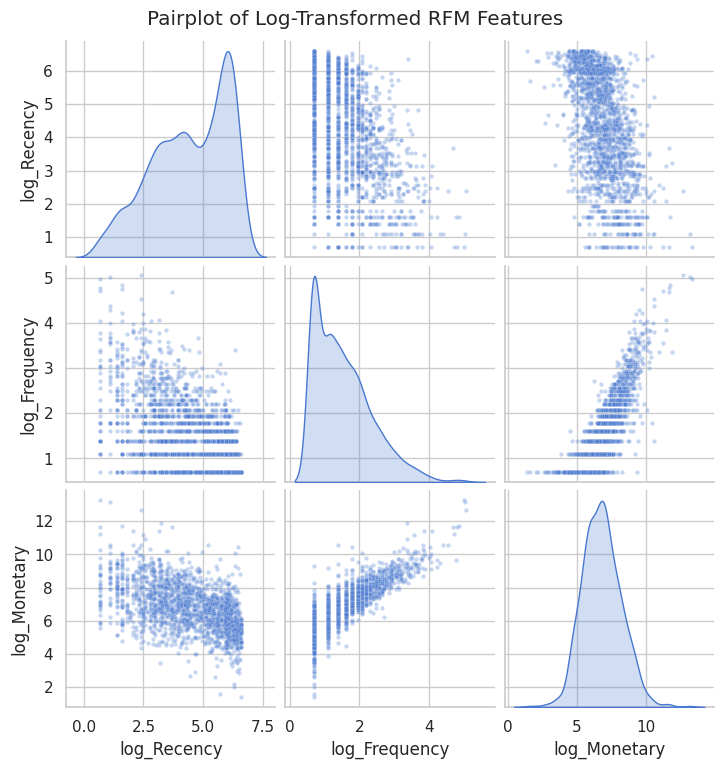

In [64]:
rfm_log = rfm.copy()
for col in cols:
    rfm_log[f"log_{col}"] = np.log1p(rfm[col])

log_cols = [f"log_{c}" for c in cols]
pair_data = rfm_log[log_cols].sample(min(2000, len(rfm_log)), random_state=42)

g = sns.pairplot(pair_data, diag_kind="kde", plot_kws={"alpha": 0.3, "s": 10})
g.fig.suptitle("Pairplot of Log-Transformed RFM Features", y=1.02)
plt.savefig("eda_pairplot.png", dpi=150)
plt.show()

### Summary Pairplot

The log_Recency has a bimodal shape, this hints at a natural cluster of very recent buyers vs. long-lapsed customers, and preview of what K-Means will finds -> qualitative motivation for clustering.

## Outlier Check (IQR)

Outlier counts per RFM feature (IQR method)

In [65]:
for col in cols:
    Q1, Q3 = rfm[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    n_out = ((rfm[col] < Q1 - 1.5*IQR) | (rfm[col] > Q3 + 1.5*IQR)).sum()
    pct   = n_out / len(rfm) * 100
    print(f"  {col:12s}: {n_out:5d} outliers ({pct:.1f}%)")

  Recency     :     0 outliers (0.0%)
  Frequency   :   427 outliers (7.3%)
  Monetary    :   633 outliers (10.8%)


## Class Imbalance Check

This creates binary target: did customer purchase in last 90 days?

purchased_next90
0    2989
1    2889
Name: count, dtype: int64
  Positive rate: 49.1%


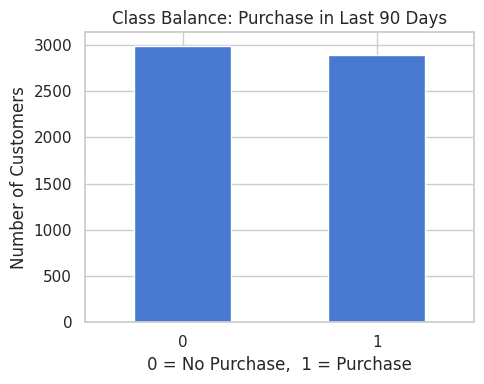

In [68]:
cutoff_date = reference_date - pd.Timedelta(days=91)
recent_buyers = set(
    df[df["InvoiceDate"] >= cutoff_date]["Customer ID"].unique()
)
rfm["purchased_next90"] = rfm["Customer ID"].isin(recent_buyers).astype(int)

balance = rfm["purchased_next90"].value_counts()


print(balance)
print(f"  Positive rate: {balance[1]/len(rfm)*100:.1f}%")

plt.figure(figsize=(5, 4))
balance.plot(kind="bar", edgecolor="white")
plt.title("Class Balance: Purchase in Last 90 Days")
plt.xlabel("0 = No Purchase,  1 = Purchase")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("eda_class_balance.png", dpi=150)
plt.show()

### Summary Class Balance

The split is approx. 50/50 so we don't need any special treatment.